# Machine Learning Process - Minneapolis 311 Data

1. Preprocessing:
  - Remove rows that still have open cases (306 removed out of 98k).
  - Engineer features: hour, day of the week, month of the year
  - Feature selection: check for highly correlated features with correlation matrix
  - Check distribution of target variable. Transform with log scale to normalize it.
  - Binarize categorical features (day of the week, neighborhood and type (title/reason)) with get_dummies
  - Aggregate all features and target variable up to the hour (creating 11412 rows). A better performance was seen with a sum aggregation than with the mean.
  

  
2. For all models:
  - Split into training/validation/test sets
  - Compare R2 and MRSE
  - Cross-validate to tune parameters, or check consistency of the model



3. Tuning models: 
  - Standardize with StandardScaler or RobustScaler (to handle outliers better)
  - Feature Selection: remove features with high variation by applying f_regression. Keep the best 95 percent of features.
  - Remove outliers: Isolation Forest
  

4. LinearRegression:
  - Plot residuals to check linearity principles and see if further transformations are needed
  - Best R-2 score (with Scaling): 0.848
  
  
  
5. RidgeRegressions:
  - Cross-validation to find best alpha
  - **Best R-2 score: 0.85**
  - *Best Cross-validation score: 0.691*
  
  
  
6. Random Forest Regressor
  - Cross-validation to find the optimal number of trees is very time-consuming.
  - Best R-2 score: 0.833 with 500 estimators 
  
  
7. Run Best Model on 2018 Data
  - Some 311 titles were added or retired in 2018. Remove all cases with these non-overlapping titles from the other years. 2018 must have the same titles as 2016/2017.
  - Preprocess 2018 data using the same steps as the training data.
  - Fit Ridge Regression model on all 2016-2017 data
  - Predict on 2018
  

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import spearmanr, pearsonr

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression, mutual_info_regression

#Try this? from sklearn.model_selection import TimeSeriesSplit

pd.set_option('display.max_columns', 100)

In [2]:
# Import data
df_all = pd.read_csv('311_all_features.csv', parse_dates = ['Date', 'closed_date', 'open_day'])
df_all.head(2)

,Date,Time,status,closed_date,days_open,reason,subject,title,object_id,x_coord,y_coord,x_geom,y_geom,opened_year,opened_month,open_day,open_time,closed_year,closed_month,max_temp,min_temp,precipitation,snow,snow_depth,geometry,hood
0,2016-01-01,00:10:35,0,2016-01-02 12:03:41,2.0,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,2196,-1.038160e+07,5.613667e+06,-93.259481,44.950087,2016,1,2016-01-01,00:10:35,2016.0,1.0,30,15,0.005,0.005,4.0,POINT (-93.25948128957221 44.95008652484643),Midtown Phillips
1,2016-01-01,07:50:34,0,2016-01-02 09:08:54,2.0,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,29550,-1.038520e+07,5.616158e+06,-93.291802,44.965918,2016,1,2016-01-01,07:50:34,2016.0,1.0,30,15,0.005,0.005,4.0,POINT (-93.29180214798036 44.96591844428954),Lowry Hill


# Feature Engineering and Preprocessing

In [3]:
# Create week_day column
df_all.loc[:, 'week_day'] = df_all.apply (lambda row: row['Date'].weekday() ,axis=1)

# Create hour column
df_all.loc[:, 'hour'] = df_all.apply (lambda row: int(row.loc['Time'][:2]) ,axis=1)

df_all.head(2)

,Date,Time,status,closed_date,days_open,reason,subject,title,object_id,x_coord,y_coord,x_geom,y_geom,opened_year,opened_month,open_day,open_time,closed_year,closed_month,max_temp,min_temp,precipitation,snow,snow_depth,geometry,hood,week_day,hour
0,2016-01-01,00:10:35,0,2016-01-02 12:03:41,2.0,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,2196,-1.038160e+07,5.613667e+06,-93.259481,44.950087,2016,1,2016-01-01,00:10:35,2016.0,1.0,30,15,0.005,0.005,4.0,POINT (-93.25948128957221 44.95008652484643),Midtown Phillips,4,0
1,2016-01-01,07:50:34,0,2016-01-02 09:08:54,2.0,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,29550,-1.038520e+07,5.616158e+06,-93.291802,44.965918,2016,1,2016-01-01,07:50:34,2016.0,1.0,30,15,0.005,0.005,4.0,POINT (-93.29180214798036 44.96591844428954),Lowry Hill,4,7


In [4]:
df_all.columns

Index(['Date', 'Time', 'status', 'closed_date', 'days_open', 'reason',
       'subject', 'title', 'object_id', 'x_coord', 'y_coord', 'x_geom',
       'y_geom', 'opened_year', 'opened_month', 'open_day', 'open_time',
       'closed_year', 'closed_month', 'max_temp', 'min_temp', 'precipitation',
       'snow', 'snow_depth', 'geometry', 'hood', 'week_day', 'hour'],
      dtype='object')

In [5]:
# Check to see how many cases are not closed. Do we stil have enough data without the open cases?
total = len(df_all)
closed = len(df_all[df_all.status == 0])

print('Number of total cases:', total)
print('Number of closed cases:', closed)
print('% of cases kept: {}'.format(closed/total*100))

Number of total cases: 98670
Number of closed cases: 98364
% of cases kept: 99.68987534204925


In [6]:
# Removing cases that are still open.
df_closed = df_all[df_all.status == 0]

# Check for highly correlated features

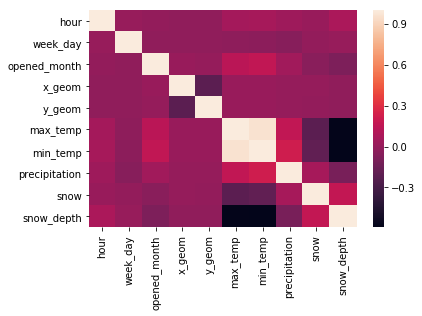

In [7]:
df_numerical = df_closed[['hour', 'week_day', 'opened_month', 'x_geom', 'y_geom', 'max_temp', 'min_temp', 
                     'precipitation', 'snow', 'snow_depth']]
corr = df_numerical.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

# The min_temp and max_temp features are highly correlated. We can remove one or take their mean.
# The min_temp is also somewhat correlated to opened_month and precipitation. We'll remove min_temp.
# Also remove snow_depth becuase it's negatively correlated with temperature.

* The min_temp and max_temp features are highly correlated. We can remove one or take their mean.
* The min_temp is also somewhat correlated to opened_month and precipitation. We'll remove min_temp.
* Also remove snow_depth becuase it's negatively correlated with temperature.

In [8]:
df = df_closed[['Date', 'hour', 'week_day', 'opened_month', 'title', 'x_geom', 'y_geom', 
       'max_temp', 'precipitation', 'snow', 'hood', 'days_open']]
df.head(2)

,Date,hour,week_day,opened_month,title,x_geom,y_geom,max_temp,precipitation,snow,hood,days_open
0,2016-01-01,0,4,1,Abandoned Vehicle - Open311,-93.259481,44.950087,30,0.005,0.005,Midtown Phillips,2.0
1,2016-01-01,7,4,1,Parking Violation - Open311,-93.291802,44.965918,30,0.005,0.005,Lowry Hill,2.0


## Are there any obvious outliers at the low end of the target variable?

In [9]:
df['days_open'].sort_values().head()

90390    0.0
49182    1.0
28849    1.0
61719    1.0
28851    1.0
Name: days_open, dtype: float64

In [10]:
df = df.drop([90390])
df['days_open'].sort_values().head()

49182    1.0
61721    1.0
61719    1.0
28849    1.0
61718    1.0
Name: days_open, dtype: float64

# Is the target variable normal?

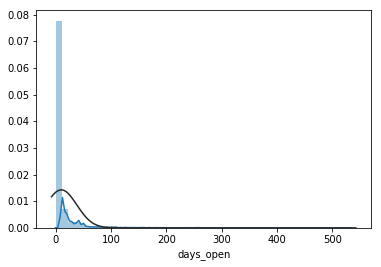

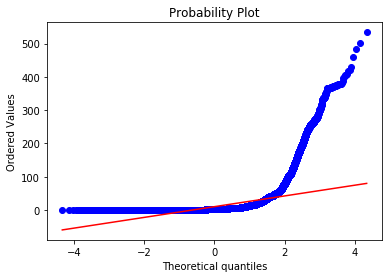

In [11]:
#histogram and normal probability plot
sns.distplot(df['days_open'],fit=norm);
fig = plt.figure()
res = stats.probplot(df['days_open'], plot=plt)

From the plots above, we can see it is not normally distributed. From our previous EDA, we know the mean days open is 3 days, visible here as a large peak on the left. There's also a very long tail which stretched past 500 days.

Linear regression is not likely to work well for this data.

In [12]:
df['days_open'] = np.log(df['days_open'])

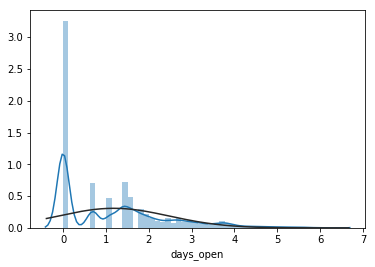

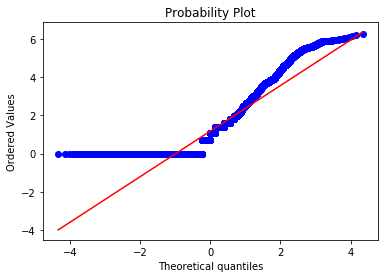

In [13]:
sns.distplot(df['days_open'],fit=norm);
fig = plt.figure()
res = stats.probplot(df['days_open'], plot=plt)

## Log transformation is a better fit
Many cases were closed within 1 day, which we see here as the line at log(y) = 0. Above that line, the distribution looks more normal. This transformation improved the linear regression model by about 30 point. We just have to remember to transform the output data back using an exponentiation.

# Predict on title

In [14]:
# Check which titles have the fewest 311 cases. When we make this feature binary,
# one column is typically dropped to avoid redundancy, 
# (since it can be inferred from the other columns). However, the rows will later be
# aggregated by hour. Dropping a column might not necessary.

df.title.value_counts().tail()

Bridge Complaint                          7
Commercial Structure Unsound              7
Water Pollution Complaint                 6
Certificate of Code Compliance Request    3
Bicycle Trail Improvement Request         2
Name: title, dtype: int64

In [15]:
# Create X columns - Title feature by hour

df_titles_hr = df[['Date', 'hour', 'title']]

# transform categorical feature to binary
X_titles_hr = pd.get_dummies(df_titles_hr)

# drop one column to avoid redundancy
X_titles_hr = X_titles_hr.drop('title_Bicycle Trail Improvement Request', axis=1)

# aggregate by day and by HOUR
X_titles_hr = X_titles_hr.groupby(['Date', 'hour']).sum().astype('float64')

# Quick view
print(len(X_titles_hr))
X_titles_hr.head(3)

11412


title_Abandoned Vehicle  title_Abandoned Vehicle - Open311  \
Date       hour                                                               
2016-01-01 0                         0.0                                1.0   
           7                         0.0                                0.0   
           8                         0.0                                0.0   

                 title_Abandoned/Illegally Parked Bicycle  \
Date       hour                                             
2016-01-01 0                                          0.0   
           7                                          0.0   
           8                                          0.0   

                 title_Air Pollution Complaint  \
Date       hour                                  
2016-01-01 0                               0.0   
           7                               0.0   
           8                               0.0   

                 title_Animal Complaint - Livability  \
Date       hour                                        
2016-01-01 0                                     0.0   
           7                                     0.0   
           8                                     0.0   

                 title_Animal Complaint - Public Health  \
Date       hour                                           
2016-01-01 0                                        0.0   
           7                                        0.0   
           8                                        0.0   

                 title_Barricade Pickup / Placement  title_Bicycle Lane Issue  \
Date       hour                                                                 
2016-01-01 0                                    0.0                       0.0   
           7                                    0.0                       0.0   
           8                                    0.0                       0.0   

                 title_Bike Lane Issue - Open311  title_Bridge Complaint  \
Date       hour                                                            
2016-01-01 0                                 0.0                     0.0   
           7                                 0.0                     0.0   
           8                                 0.0                     0.0   

                 title_Campaign Sign Complaint  \
Date       hour                                  
2016-01-01 0                               0.0   
           7                               0.0   
           8                               0.0   

                 title_Certificate of Code Compliance Request  \
Date       hour                                                 
2016-01-01 0                                              0.0   
           7                                              0.0   
           8                                              0.0   

                 title_Certificate of Occupancy Request  title_Chemical Spill  \
Date       hour                                                                 
2016-01-01 0                                        0.0                   0.0   
           7                                        0.0                   0.0   
           8                                        0.0                   0.0   

                 title_Commercial Disability Zone  \
Date       hour                                     
2016-01-01 0                                  0.0   
           7                                  0.0   
           8                                  0.0   

                 title_Commercial Food Safety/Sanitation Complaint  \
Date       hour                                                      
2016-01-01 0                                                   0.0   
           7                                                   0.0   
           8                                                   0.0   

                 title_Commercial Structure Unsound  \
Date       hour                              

In [16]:
# Create y (target variable)

y = df[['Date', 'hour', 'days_open']]

# aggregate by day and by HOUR
y = y.groupby(['Date', 'hour']).sum()

# View
print(len(y))
print(y.shape)
y.head(3)

11412
(11412, 1)


days_open
Date       hour           
2016-01-01 0      0.693147
           7      0.693147
           8      3.663562

In [17]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),  #with_mean=False
        ('lm', LinearRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_titles_hr, y, test_size = 0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
lm_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
lm_unscaled = LinearRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(lm_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(lm_unscaled.score(X_test, y_test)))

#No log transformation on Y: 0.5472132572806965
#With log transformation on Y, then aggregate: 0.8340747888599083
# Aggregate to the hour, then take log scale of Y: 0.5838645887970061

Accuracy with Scaling: 0.8340747888599083
Accuracy without Scaling: 0.8340747888599083


## No visible improvement from scaling the data at this level.


In [18]:
## Linear Regression Function ##

def LinRegEval(X, y):
    '''Returns LinearRegression stats and scatter plot of observed vs predicted values.'''

    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=43)

    lm = LinearRegression()
    # Fit the regressor to the training data
    lm.fit(X_train, y_train)

    # Predict on the train and test data
    predicted_train = lm.predict(X_train)
    predicted_test = lm.predict(X_test)
    test_score = lm.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_test)) 
    spearman = spearmanr(y_test, predicted_test)
    pearson = pearsonr(y_test, predicted_test)

    # Compute and print R^2 and RMSE
    print(f'Test data R-2 score: {test_score:>5.3}')
    print(f'Root Mean Squared Error: {rmse:.4}')
    print(f'Estimated intercept coefficient: {lm.intercept_[0]:.4}')
    print(f'Test data Spearman correlation: {spearman[0]:.3}')
    print(f'Test data Pearson correlation: {pearson[0][0]:.3}')

    # scatter plot between predicted days_open (lr.predict(X)) and actuals
    fig, ax = plt.subplots(figsize=(6, 5))
#    sns.regplot(x=lm.predict(X), y=y, fit_reg = True, scatter_kws={'alpha':0.5, 's':60})
    sns.regplot(x=lm.predict(X), y=y['days_open'], fit_reg = True, scatter_kws={'alpha':0.5, 
                                                                                's':60})
                
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.title("Days Open")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = -cross_val_score(lm, X, y, cv = 5, scoring='neg_mean_squared_error')

    # Print the 5-fold cross-validation scores
    print("Cross-Validation Scores: {}".format(cv_scores, 3))
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

    # Make cross validated predictions
    predictions = cross_val_predict(lm, X, y, cv=5)
    accuracy = r2_score(y, predictions)
    print ('Cross-Predicted Accuracy: %0.3f' % (accuracy))
    
    plt.scatter(predicted_train, predicted_train - y_train, c='b', s=40, alpha=.5)
    plt.scatter(predicted_test, predicted_test - y_test, c='g', s=40, alpha=.6) 
    plt.hlines(y=0, xmin=-10, xmax=50)
    
    plt.xlabel("Residuals")
    plt.ylabel("Fitted Values")
    plt.title("Days Open")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    

Test data R-2 score: 0.813
Root Mean Squared Error: 4.89
Estimated intercept coefficient: 0.07523
Test data Spearman correlation: 0.927
Test data Pearson correlation: 0.903


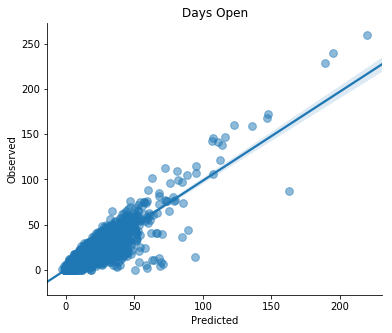

Cross-Validation Scores: [ 16.26710124  17.94532524  63.07519133  25.45635909 116.53438035]
Accuracy: 47.86 (+/- 76.64)
Cross-Predicted Accuracy: 0.676


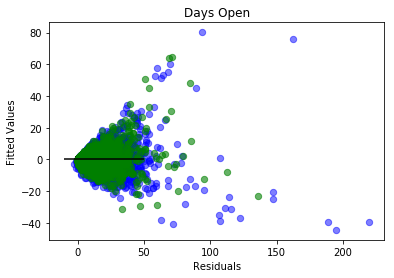

In [19]:
# Apply linear regression to titles data
LinRegEval(X_titles_hr, y)


In [20]:
#print(X_titles_hr.shape)
#(150, 4)
#X_titles_hr_new = SelectKBest(mutual_info_regression, k=20).fit_transform(X_titles_hr, y['days_open'])
#print(X_titles_hr_new.shape)

# Apply linear regression to titles data
#LinRegEval(X_titles_hr_new, y)

### Very slow to run (k=10: R2= 0.04, k=20: R2=0.06)  ###

(11412, 91)
(11412, 80)
Test data R-2 score: 0.807
Root Mean Squared Error: 4.971
Estimated intercept coefficient: 0.4266
Test data Spearman correlation: 0.911
Test data Pearson correlation: 0.9


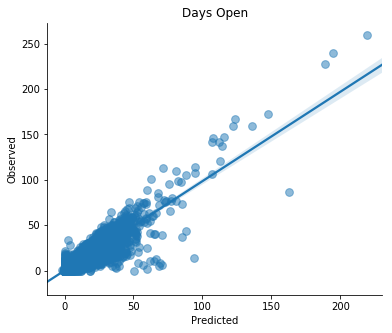

Cross-Validation Scores: [ 17.21675919  18.8165089   65.23810245  26.77123137 116.10222652]
Accuracy: 48.83 (+/- 75.80)
Cross-Predicted Accuracy: 0.669


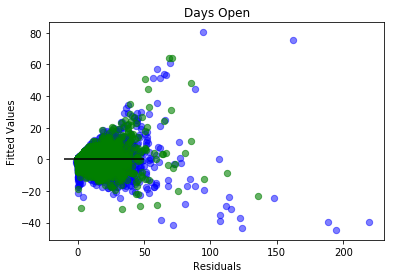

In [21]:
# Feature selection with f_regression

print(X_titles_hr.shape)

X_titles_hr_new = SelectKBest(f_regression, k=80).fit_transform(X_titles_hr, y['days_open'])
print(X_titles_hr_new.shape)

# Apply linear regression to titles data
LinRegEval(X_titles_hr_new, y)


(11412, 91)
(11412, 86)
Test data R-2 score: 0.814
Root Mean Squared Error: 4.879
Estimated intercept coefficient: 0.1005
Test data Spearman correlation: 0.928
Test data Pearson correlation: 0.904


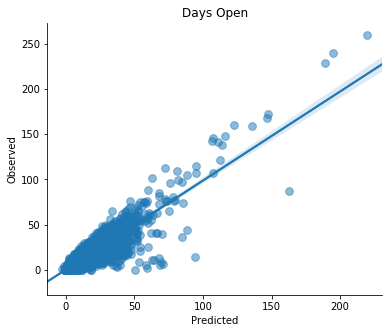

Cross-Validation Scores: [ 16.19188205  17.9511995   63.05105037  25.49672695 116.6329726 ]
Accuracy: 47.86 (+/- 76.72)
Cross-Predicted Accuracy: 0.675


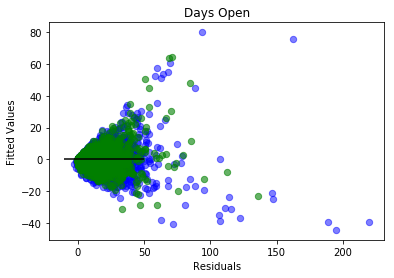

In [22]:
# Feature selection with f_regression

print(X_titles_hr.shape)

X_titles_hr_new = SelectPercentile(f_regression, percentile=95).fit_transform(X_titles_hr, y['days_open'])
print(X_titles_hr_new.shape)

# Apply linear regression to titles data
LinRegEval(X_titles_hr_new, y)

# Outliers
Currently, this model isn't predicting any case will be open for more than 45 days.   

What if we considered outliers to be any case open for longer than 50 days? Or 100 days? How much would the model improve?

# Predict on neighborhood

In [23]:
df_hood = df_closed[['Date', 'hour', 'hood']]
X_hood = pd.get_dummies(df_hood)
X_hood = X_hood.groupby(['Date', 'hour']).sum().astype('float64')
X_hood.head(2)


hood_Armatage  hood_Audubon Park  hood_Bancroft  \
Date       hour                                                    
2016-01-01 0               0.0                0.0            0.0   
           7               0.0                0.0            0.0   

                 hood_Beltrami  hood_Bottineau  hood_Bryant  hood_Bryn - Mawr  \
Date       hour                                                                 
2016-01-01 0               0.0             0.0          0.0               0.0   
           7               0.0             0.0          0.0               0.0   

                 hood_CARAG  hood_Camden Industrial  \
Date       hour                                       
2016-01-01 0            0.0                     0.0   
           7            0.0                     0.0   

                 hood_Cedar - Isles - Dean  hood_Cedar Riverside  \
Date       hour                                                    
2016-01-01 0                           0.0                   0.0   
           7                           0.0                   0.0   

                 hood_Central  hood_Cleveland  hood_Columbia Park  hood_Como  \
Date       hour                                                                
2016-01-01 0              0.0             0.0                 0.0        0.0   
           7              0.0             0.0                 0.0        0.0   

                 hood_Cooper  hood_Corcoran  hood_Diamond Lake  \
Date       hour                                                  
2016-01-01 0             0.0            0.0                0.0   
           7             0.0            0.0                0.0   

                 hood_Downtown East  hood_Downtown West  hood_ECCO  \
Date       hour                                                      
2016-01-01 0                    0.0                 0.0        0.0   
           7                    0.0                 0.0        0.0   

                 hood_East Harriet  hood_East Isles  hood_East Phillips  \
Date       hour                                                           
2016-01-01 0                   0.0              0.0                 0.0   
           7                   0.0              0.0                 0.0   

                 hood_Elliot Park  hood_Ericsson  hood_Field  hood_Folwell  \
Date       hour                                                              
2016-01-01 0                  0.0            0.0         0.0           0.0   
           7                  0.0            0.0         0.0           0.0   

                 hood_Fulton  hood_Hale  hood_Harrison  hood_Hawthorne  \
Date       hour                                                          
2016-01-01 0             0.0        0.0            0.0             0.0   
           7             0.0        0.0            0.0             0.0   

                 hood_Hiawatha  hood_Holland  hood_Howe  \
Date       hour                                           
2016-01-01 0               0.0           0.0        0.0   
           7               0.0           0.0        0.0   

                 hood_Humboldt Industrial Area  hood_Jordan  hood_Keewaydin  \
Date       hour                                                               
2016-01-01 0                               0.0          0.0             0.0   
           7                               0.0          0.0             0.0   

                 hood_Kenny  hood_Kenwood  hood_King Field  \
Date       hour                                              
2016-01-01 0            0.0           0.0              0.0   
           7            0.0           0.0              0.0   

                 hood_Lind - Bohanon  hood_Linden Hills  hood_Logan Park  \
Date       hour                                                            
2016-01-01 0                     0.0                0.0              0.0   
           7                     0.0                0.0              0.0   

                 hood_Longfellow  hood_

Test data R-2 score: 0.674
Root Mean Squared Error: 6.456
Estimated intercept coefficient: -1.663
Test data Spearman correlation: 0.867
Test data Pearson correlation: 0.825


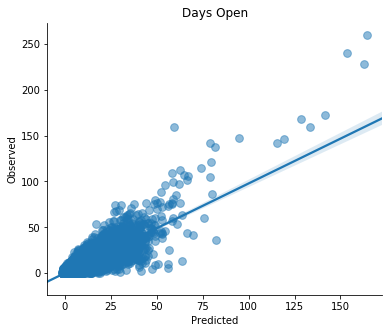

Cross-Validation Scores: [ 23.8623413   34.71802828  40.10810582  47.97008644 117.33067963]
Accuracy: 52.80 (+/- 66.41)
Cross-Predicted Accuracy: 0.642


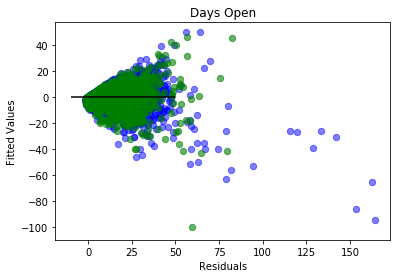

In [24]:
# Apply linear regression to neighborhood data
LinRegEval(X_hood, y)

# Predict on more features

In [25]:
df_nums = df_closed[['Date', 'hour', 'week_day', 'opened_month', 'x_geom', 'y_geom', 'max_temp', 
                     'precipitation']]
X_nums_hr = df_nums.groupby(['Date', 'hour']).sum().astype('float64')

#.agg({'x_geom':'mode', 'y_geom':'mode', 'max_temp':'mean', 'min_temp':'mean', 
#    'precipitation':'mean', 'snow_depth':'mean'})

X_nums_hr.head(2)

week_day  opened_month     x_geom     y_geom  max_temp  \
Date       hour                                                           
2016-01-01 0          4.0           1.0 -93.259481  44.950087      30.0   
           7          4.0           1.0 -93.291802  44.965918      30.0   

                 precipitation  
Date       hour                 
2016-01-01 0             0.005  
           7             0.005

In [26]:
#dummy_cols = ['reason', 'hood']
#train = pd.get_dummies(df, columns = dummy_cols)

In [27]:
# Create df with all numerical features and titles

X_all = pd.concat([X_titles_hr, X_nums_hr, X_hood], axis=1, join='outer')
#Test data R-2 score: 0.828
#Root Mean Squared Error: 4.683
#Cross-Predicted Accuracy: 0.687

#X_all = pd.concat([X_titles_hr, X_nums_hr], axis=1, join='outer')
#Test data R-2 score: 0.823
#Root Mean Squared Error: 4.754
#Cross-Predicted Accuracy: 0.686

# Use the hour column as a feature
X_all = X_all.reset_index(level=['hour'])
X_all.head(2)

,hour,title_Abandoned Vehicle,title_Abandoned Vehicle - Open311,title_Abandoned/Illegally Parked Bicycle,title_Air Pollution Complaint,title_Animal Complaint - Livability,title_Animal Complaint - Public Health,title_Barricade Pickup / Placement,title_Bicycle Lane Issue,title_Bike Lane Issue - Open311,title_Bridge Complaint,title_Campaign Sign Complaint,title_Certificate of Code Compliance Request,title_Certificate of Occupancy Request,title_Chemical Spill,title_Commercial Disability Zone,title_Commercial Food Safety/Sanitation Complaint,title_Commercial Structure Unsound,title_Commercial/Mixed Conditions Complaint,title_Debris in the Street or Alley,title_Emergency Pollution Complaint,title_Exterior Nuisance - Self Service,title_Exterior Nuisance Complaint,title_Fence or Guardrail Maintenance,title_Fire Rig Visit Request,title_Full TISH Report Request,title_General Street Complaint,title_Graffiti - Open311,title_Graffiti complaint / reporting,title_Grass & Weed Complaint,title_Hoarding,title_Homeless Encampment,title_Hydrant Issue,title_Illegal Dumping Complaint,title_Inoperable Vehicle Complaint,title_K9 Appearance Request,title_Land Pollution Complaint,title_Licensing Complaint,title_Neighborhood Parking Information,title_Noise Pollution Complaint,title_Parking Meter - Open311,title_Parking Meter Problem,title_Parking Violation - Open311,title_Parking Violation Complaint,title_Police Mounted Patrol Request,title_Pothole,title_Pothole - Open311,title_RHOD Conditions Complaint,title_RHOD Exterior Nuisance Complaint,title_Repair Notice Question,...,hood_Keewaydin,hood_Kenny,hood_Kenwood,hood_King Field,hood_Lind - Bohanon,hood_Linden Hills,hood_Logan Park,hood_Longfellow,hood_Loring Park,hood_Lowry Hill,hood_Lowry Hill East,hood_Lyndale,hood_Lynnhurst,hood_Marcy Holmes,hood_Marshall Terrace,hood_McKinley,hood_Mid - City Industrial,hood_Midtown Phillips,hood_Minnehaha,hood_Morris Park,hood_Near - North,hood_Nicollet Island - East Bank,hood_North Loop,hood_Northeast Park,hood_Northrop,hood_Page,hood_Phillips West,hood_Powderhorn Park,hood_Prospect Park - East River Road,hood_Regina,hood_Seward,hood_Sheridan,hood_Shingle Creek,hood_St. Anthony East,hood_St. Anthony West,hood_Standish,hood_Steven's Square - Loring Heights,hood_Sumner - Glenwood,hood_Tangletown,hood_University of Minnesota,hood_Ventura Village,hood_Victory,hood_Waite Park,hood_Webber - Camden,hood_Wenonah,hood_West Calhoun,hood_Whittier,hood_Willard - Hay,hood_Windom,hood_Windom Park
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Test data R-2 score: 0.828
Root Mean Squared Error: 4.683
Estimated intercept coefficient: 0.3659
Test data Spearman correlation: 0.925
Test data Pearson correlation: 0.911


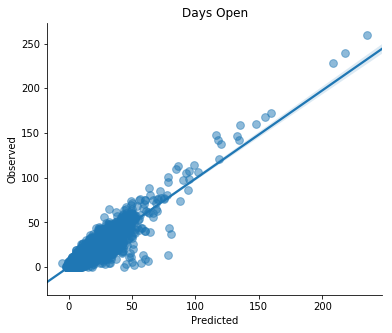

Cross-Validation Scores: [ 16.22220599  22.15472075  59.06162547  30.66608066 102.61796844]
Accuracy: 46.14 (+/- 63.66)
Cross-Predicted Accuracy: 0.687


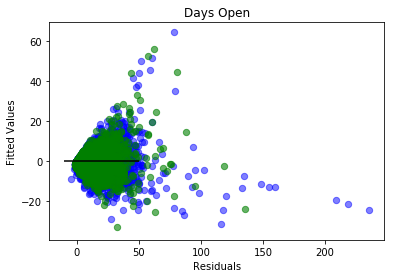

In [28]:
# Apply linear regression to all features
LinRegEval(X_all, y)

(11412, 185)
(11412, 175)
Test data R-2 score: 0.827
Root Mean Squared Error: 4.695
Estimated intercept coefficient: 0.3179
Test data Spearman correlation: 0.924
Test data Pearson correlation: 0.911


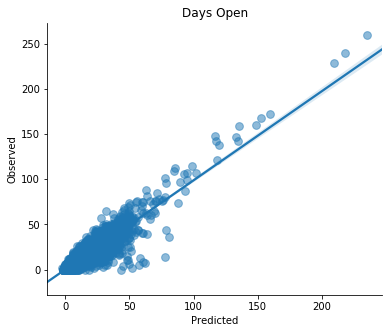

Cross-Validation Scores: [ 16.26346905  22.27521805  59.10788831  30.88958273 102.49043913]
Accuracy: 46.21 (+/- 63.49)
Cross-Predicted Accuracy: 0.687


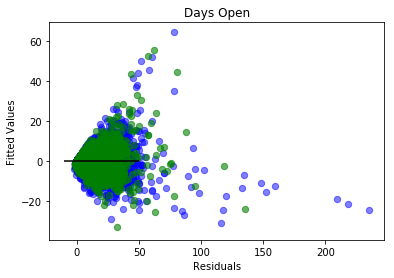

In [29]:
# Feature selection with f_regression

print(X_all.shape)

X_all_new = SelectPercentile(f_regression, percentile=95).fit_transform(X_all, y['days_open'])
print(X_all_new.shape)

# Apply linear regression to titles data
LinRegEval(X_all_new, y)

In [30]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),  #with_mean=False
        ('lm', LinearRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size = 0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
lm_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
lm_unscaled = LinearRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(lm_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(lm_unscaled.score(X_test, y_test)))

/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Accuracy with Scaling: 0.8451509732752344
Accuracy without Scaling: 0.845150973275223


/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [31]:
## Linear Regression Function ##

def LinRegEval_scaled(X, y):
    '''Returns LinearRegression stats and scatter plot of observed vs predicted values.'''
    
    # Setup LinearRegression
#    lm = LinearRegression()

    
#    scaler = StandardScaler().fit(X_train)
#    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, 
#                                  columns=X_train.columns.values)
#    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, 
#                                 columns=X_test.columns.values)     
    # Setup the pipeline steps: steps
    steps = [('scaler', StandardScaler()),  #with_mean=False
            ('lm', LinearRegression())]
        
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)

    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                        random_state=42)

    # Fit the lm to the training set
    lm_scaled = pipeline.fit(X_train, y_train)


    # Predict on the train and test data
    predicted_train = lm_scaled.predict(X_train)
    predicted_test = lm_scaled.predict(X_test)
    test_score = lm_scaled.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_test)) 
    spearman = spearmanr(y_test, predicted_test)
    pearson = pearsonr(y_test, predicted_test)

    # Compute and print R^2 and RMSE
    print(f'Test data R-2 score: {test_score:.3}')
    print(f'Root Mean Squared Error: {rmse:.4}')
#    print(f'Estimated intercept coefficient: {lm_scaled.intercept_[0]:.4}')
    print(f'Test data Spearman correlation: {spearman[0]:.3}')
    print(f'Test data Pearson correlation: {pearson[0][0]:.3}')

    # scatter plot between predicted days_open (lr.predict(X)) and actuals
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.regplot(x=lm_scaled.predict(X), y=y['days_open'], fit_reg = True, 
                scatter_kws={'alpha':0.5, 's':60})

    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.title("Days Open")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = -cross_val_score(lm_scaled, X, y, cv = 5, scoring='neg_mean_squared_error')

    # Print the 5-fold cross-validation scores
    print("Cross-Validation Scores: {}".format(cv_scores, 3))
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

    # Make cross validated predictions
    predictions = cross_val_predict(lm_scaled, X, y, cv=5)
    accuracy = r2_score(y, predictions)
    print ('Cross-Predicted Accuracy: %0.3f' % (accuracy))

In [32]:
# Apply linear regression to all features
#LinRegEval_scaled(X_all, y)

#Plotting error: "ValueError: shapes (11412,185) and (91,1) not aligned: 185 (dim 1) != 91 (dim 0)"

(11412, 185)
(11412, 157)
Test data R-2 score: 0.825
Root Mean Squared Error: 4.734
Estimated intercept coefficient: 0.3501
Test data Spearman correlation: 0.922
Test data Pearson correlation: 0.909


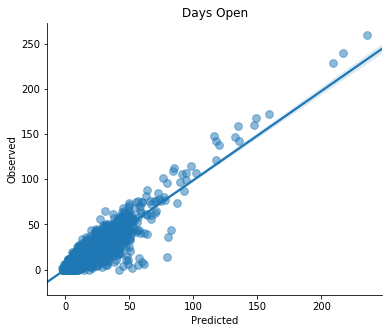

Cross-Validation Scores: [ 16.11216453  22.14663781  58.78307377  32.12286784 102.82207704]
Accuracy: 46.40 (+/- 63.54)
Cross-Predicted Accuracy: 0.685


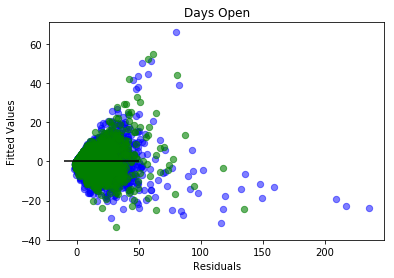

In [33]:
# Select best 85% of features
X_all_hr_new = SelectPercentile(f_regression, percentile=85).fit_transform(X_all, y['days_open'])
print(X_all.shape)
print(X_all_hr_new.shape)

# Apply linear regression to all features
LinRegEval(X_all_hr_new, y)

In [34]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size = .3, random_state=42)

# Create the regressor: lm
lm = LinearRegression()

# Fit the regressor to the training data
lm.fit(X_train, y_train)
#lm.coef_
# The coefficients
feature_coef = pd.DataFrame({'features': X_all.columns, 
                             'estimatedCoefficients': lm.coef_[0]})[[
                             'features', 'estimatedCoefficients']]

print(feature_coef.sort_values('estimatedCoefficients').head())
print(feature_coef.sort_values('estimatedCoefficients').tail())

                          features  estimatedCoefficients
133  hood_Humboldt Industrial Area            -144.595749
119              hood_East Harriet            -144.555206
112                      hood_Como            -144.150067
105                     hood_CARAG            -143.637494
100                  hood_Bancroft            -143.583867
                               features  estimatedCoefficients
64             title_Speed Hump Request               6.979420
30                       title_Hoarding               7.318451
50    title_Residential Disability Zone               7.727229
44  title_Police Mounted Patrol Request               8.957532
67             title_Street Light - New               9.088722


The titles with a lot of outliers seem to be the most influential features.

# Predict using only data available in the 311 API

In [35]:
#Extract only numerical features available in the 311 API
df_311_num = df_closed[['Date', 'hour', 'week_day', 'opened_month', 'x_geom', 'y_geom']]

#Aggregate by the hour
X_311_nums_hr = df_311_num.groupby(['Date', 'hour']).sum()

#Combine with title features
X_311 = pd.concat([X_titles_hr, X_311_nums_hr], axis=1, join='outer')

# Use the hour column as a feature instead of just an index
X_311 = X_311.reset_index(level=['hour']).astype('float64')

X_311.head(2)

,hour,title_Abandoned Vehicle,title_Abandoned Vehicle - Open311,title_Abandoned/Illegally Parked Bicycle,title_Air Pollution Complaint,title_Animal Complaint - Livability,title_Animal Complaint - Public Health,title_Barricade Pickup / Placement,title_Bicycle Lane Issue,title_Bike Lane Issue - Open311,title_Bridge Complaint,title_Campaign Sign Complaint,title_Certificate of Code Compliance Request,title_Certificate of Occupancy Request,title_Chemical Spill,title_Commercial Disability Zone,title_Commercial Food Safety/Sanitation Complaint,title_Commercial Structure Unsound,title_Commercial/Mixed Conditions Complaint,title_Debris in the Street or Alley,title_Emergency Pollution Complaint,title_Exterior Nuisance - Self Service,title_Exterior Nuisance Complaint,title_Fence or Guardrail Maintenance,title_Fire Rig Visit Request,title_Full TISH Report Request,title_General Street Complaint,title_Graffiti - Open311,title_Graffiti complaint / reporting,title_Grass & Weed Complaint,title_Hoarding,title_Homeless Encampment,title_Hydrant Issue,title_Illegal Dumping Complaint,title_Inoperable Vehicle Complaint,title_K9 Appearance Request,title_Land Pollution Complaint,title_Licensing Complaint,title_Neighborhood Parking Information,title_Noise Pollution Complaint,title_Parking Meter - Open311,title_Parking Meter Problem,title_Parking Violation - Open311,title_Parking Violation Complaint,title_Police Mounted Patrol Request,title_Pothole,title_Pothole - Open311,title_RHOD Conditions Complaint,title_RHOD Exterior Nuisance Complaint,title_Repair Notice Question,title_Residential Disability Zone,title_Sewer Issues,title_Sidewalk Obstruction Complaint,title_Sidewalk Snow & Ice Complaint,title_Sidewalk Snow Ice - Open311,title_Sidewalk Snow and Ice - SS,title_Sidewalk Structural - Open311,title_Sidewalk Structural Complaint,title_Sign Complaint,title_Snow & Ice Complaint,title_Snow - Illegal Dumping,title_Solid Waste Overflow Litter,title_Solid Waste Overflowing Litter - Open311,title_Special Sweep,title_Speed Hump Request,title_Speed Wagon,title_Sport Equip in Street,title_Street Light - New,title_Street Light Outage,title_Street Light Outage - Open311,title_Street Light Trouble,title_Street Light Trouble - Open311,title_Street Light Wreck - Open311,title_Street Light Wreck/Damage,title_Streets Snow & Ice - Open311,title_Traffic Sign - New,title_Traffic Sign - Removal,title_Traffic Sign - Repair,title_Traffic Sign Repair - Open311,title_Traffic Signal - New/Modification,title_Traffic Signal Timing - Open311,title_Traffic Signal Timing Issue,title_Traffic Signal Trouble,title_Traffic Signal Trouble - Open311,title_Trees Down,title_Unpermitted Work,title_Unpermitted Work - Self Service,title_Urgent Pollution Complaint,title_Vacant Building / Open to Trespass,title_Vacant Building / Open to Trespass Boarded,title_Water Main Break,title_Water Pollution Complaint,week_day,opened_month,x_geom,y_geom
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,-93.259481,44.950087
2016-01-01,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,-93.291802,44.965918


Test data R-2 score: 0.823
Root Mean Squared Error: 4.762
Estimated intercept coefficient: 0.3977
Test data Spearman correlation: 0.928
Test data Pearson correlation: 0.908


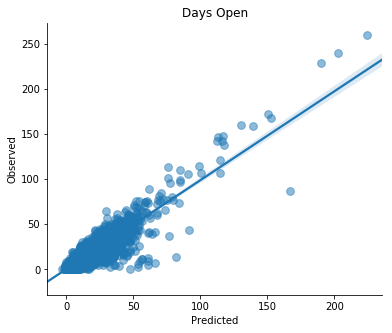

Cross-Validation Scores: [ 17.12924929  20.54894268  60.79129277  27.23121575 103.09654982]
Accuracy: 45.76 (+/- 65.19)
Cross-Predicted Accuracy: 0.690


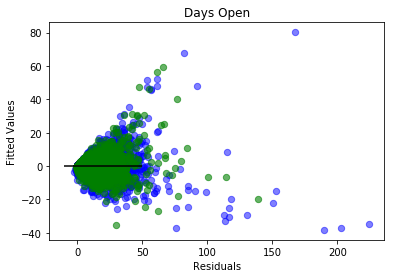

In [36]:
# Apply linear regression to all features
LinRegEval(X_311, y)

In [37]:
# Setup the pipeline steps: steps
steps = [('scaler', RobustScaler()),  #with_mean=False
        ('lm', LinearRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_311, y, test_size = 0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
lm_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
lm_unscaled = LinearRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling:    {}'.format(lm_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(lm_unscaled.score(X_test, y_test)))

Accuracy with Scaling:    0.8489847375963832
Accuracy without Scaling: 0.8489847375963857


Test data R-2 score: 0.849
Root Mean Squared Error: 4.622
Test data Spearman correlation: 0.925
Test data Pearson correlation: 0.921


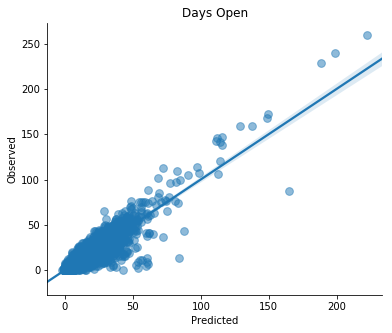

Cross-Validation Scores: [1.71292493e+01 2.05489427e+01 6.07912928e+01 2.72312158e+01
 1.83562744e+26]
Accuracy: 36712548722207868449718272.00 (+/- 146850194888831473798873088.00)
Cross-Predicted Accuracy: -248907316803387502100480.000


In [38]:
# Apply linear regression to 311 features
LinRegEval_scaled(X_311, y)

### Reducing dimensions has helped!
The weather data and neighborhood features may have been correlated with the original 311 features and causing noise. Removing those features also makes it easier for the City as they can use their existing data to build predictions.

# Ridge Regression

In [39]:
def RidgeEval(X, y):
    '''Splits data into train, validation and test sets. Cross validates alpha values for Ridge Regression.'''
    
    # Create training, validationg and test sets
    # intermediate/test split (gives us test set)
    X_intermediate, X_test, y_intermediate, y_test = train_test_split(X, y,  
                                                                  shuffle=True,
                                                                  test_size=0.2, 
                                                                  random_state=14)

    # train/validation split (gives us train and validation sets)
    X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate,
                                                                y_intermediate,
                                                                shuffle=False,
                                                                test_size=0.25,
                                                                random_state=42)
    # delete intermediate variables
    del X_intermediate, y_intermediate

    # print proportions
    print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(y),2),
                                                       round(len(y_validation)/len(y),2),
                                                       round(len(y_test)/len(y),2)))
    alphas = [0.01, 0.1, 1, 10, 100, 1000]
    print('All errors are RMSE')
    print('-'*76)
    for alpha in alphas:
        # instantiate and fit model
        ridge = Ridge(alpha=alpha, fit_intercept=True, random_state=99)
        ridge.fit(X_train, y_train)
        # calculate errors
        new_train_error = mean_squared_error(y_train, ridge.predict(X_train))
        new_validation_error = mean_squared_error(y_validation, ridge.predict(X_validation))
        new_test_error = mean_squared_error(y_test, ridge.predict(X_test))
        # print errors as report
        print('alpha: {:7} | train error: {:5} | val error: {:6} | test error: {}'.
              format(alpha,
                     round(new_train_error,3),
                     round(new_validation_error,3),
                     round(new_test_error,3)))


In [40]:
RidgeEval(X_all, y)

train: 0.6% | validation: 0.2% | test 0.2%
All errors are RMSE
----------------------------------------------------------------------------
alpha:    0.01 | train error: 18.362 | val error: 19.668 | test error: 29.817
alpha:     0.1 | train error: 18.365 | val error: 19.649 | test error: 29.796
alpha:       1 | train error: 18.371 | val error: 19.607 | test error: 29.697
alpha:      10 | train error: 18.413 | val error: 19.606 | test error: 29.554
alpha:     100 | train error: 18.737 | val error: 19.848 | test error: 29.737
alpha:    1000 | train error: 20.317 | val error: 21.311 | test error: 31.424


In [41]:
RidgeEval(X_titles_hr, y)

train: 0.6% | validation: 0.2% | test 0.2%
All errors are RMSE
----------------------------------------------------------------------------
alpha:    0.01 | train error: 21.667 | val error: 22.004 | test error: 35.39
alpha:     0.1 | train error: 21.667 | val error: 21.994 | test error: 35.37
alpha:       1 | train error: 21.671 | val error: 21.939 | test error: 35.256
alpha:      10 | train error: 21.728 | val error: 21.879 | test error: 35.048
alpha:     100 | train error: 22.347 | val error:  22.48 | test error: 35.439
alpha:    1000 | train error: 26.517 | val error: 27.384 | test error: 39.78


In [42]:
RidgeEval(X_311, y)

train: 0.6% | validation: 0.2% | test 0.2%
All errors are RMSE
----------------------------------------------------------------------------
alpha:    0.01 | train error: 20.119 | val error: 20.308 | test error: 32.245
alpha:     0.1 | train error: 20.121 | val error: 20.298 | test error: 32.226
alpha:       1 | train error: 20.126 | val error: 20.258 | test error: 32.146
alpha:      10 | train error: 20.169 | val error: 20.261 | test error: 32.042
alpha:     100 | train error: 20.502 | val error: 20.571 | test error: 32.212
alpha:    1000 | train error: 21.88 | val error: 22.193 | test error: 33.292


## Best alpha = 10 for the validation and test sets

Test data R-2 score: 0.846
Test data Spearman correlation: 0.921
Test data Pearson correlation: 0.92


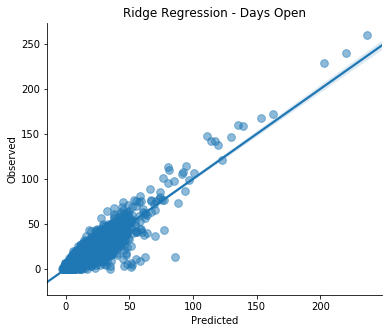

Cross-Validation Scores: [ 16.0552048   21.71043869  58.91694722  30.57872246 102.14005932]
Accuracy: 45.88 (+/- 63.52)
Cross-Predicted Accuracy: 0.689


In [43]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y['days_open'], test_size = .3, 
                                                    random_state=42)

# Fit model to training data
ridge = Ridge(alpha=10, fit_intercept=True, random_state=44)
ridge.fit(X_train, y_train)

# Predict and view stats
predicted_train = ridge.predict(X_train)
predicted_test = ridge.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

# scatter plot between predicted days_open and actuals
fig, ax = plt.subplots(figsize=(6, 5))
sns.regplot(x=ridge.predict(X_all), y=y['days_open'], fit_reg = True, scatter_kws={'alpha':0.5,
                                                                                   's':60})

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Ridge Regression - Days Open")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = -cross_val_score(ridge, X_all, y, cv = 5, scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print("Cross-Validation Scores: {}".format(cv_scores, 3))
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

# Make cross validated predictions
predictions = cross_val_predict(ridge, X_all, y, cv=5)
accuracy = r2_score(y, predictions)
print ('Cross-Predicted Accuracy: %0.3f' % (accuracy))

#Best R-2 score: 0.846

### Ridge with Scaling

In [44]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),  #with_mean=False
        ('ridge', Ridge(alpha=10, fit_intercept=True, random_state=44))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size = 0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
ridge_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
ridge_unscaled = Ridge(alpha=10, fit_intercept=True, random_state=44).fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(ridge_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(ridge_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.845079972911098
Accuracy without Scaling: 0.8460069782370476


/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


## Ridge Regression with X_311

Test data R-2 score:  0.85
Test data Spearman correlation: 0.926
Test data Pearson correlation: 0.922


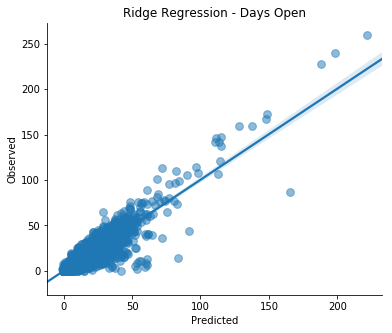

Cross-Validation Scores: [ 16.90623417  20.2071374   60.66812069  27.26858351 103.11118549]
Accuracy: 45.63 (+/- 65.35)
Cross-Predicted Accuracy: 0.691


In [45]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_311, y['days_open'], test_size = .3, 
                                                    random_state=42)

# Fit model to training data
ridge = Ridge(alpha=10, fit_intercept=True, random_state=44)
ridge.fit(X_train, y_train)

# Predict and view stats
predicted_train = ridge.predict(X_train)
predicted_test = ridge.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

# scatter plot between predicted days_open and actuals
fig, ax = plt.subplots(figsize=(6, 5))
sns.regplot(x=ridge.predict(X_311), y=y['days_open'], fit_reg = True, scatter_kws={
    'alpha':0.5, 's':60})

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Ridge Regression - Days Open")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = -cross_val_score(ridge, X_311, y, cv = 5, scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print("Cross-Validation Scores: {}".format(cv_scores, 3))
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

# Make cross validated predictions
predictions = cross_val_predict(ridge, X_311, y, cv=5)
accuracy = r2_score(y, predictions)
print ('Cross-Predicted Accuracy: %0.3f' % (accuracy))

#Best R-2 score: 0.85

# Random Forest Regressor

Out-of-bag R-2 score estimate: 0.812
Test data R-2 score: 0.833
Test data Spearman correlation: 0.92
Test data Pearson correlation: 0.913


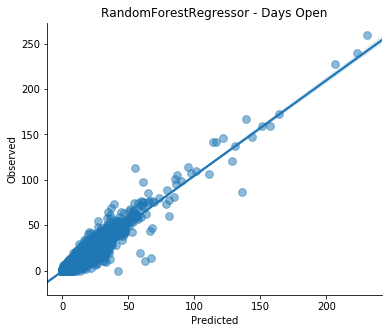

In [46]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_311, y['days_open'], test_size = .3, 
                                                    random_state=42)

# Fit RandomForestRegressor (rfr) model to training data
#rf = rfr(n_estimators=500, oob_score=True, random_state=0)
rf = rfr(n_estimators=100, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

# Predict and view stats
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

# scatter plot between predicted days_open and actuals
fig, ax = plt.subplots(figsize=(6, 5))
sns.regplot(x=rf.predict(X_311), y=y['days_open'], fit_reg = True, scatter_kws={'alpha':0.5, 
                                                                                's':60})

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("RandomForestRegressor - Days Open")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


### RESULT ###
# X_titles_hr, n = 100: oob score = 0.78
# X_all, n = 100: oob score = 0.799
# X_all, n = 300: oob score = 0.804
# X_all, n = 500: oob score = 0.807, R-2 score = 0.818

# X_311, n = 100: oob score = 0.812, R-2 score = 0.833
# X_3ll, n = 500: oob score = 0.818, R-2 score = 0.833

# Removing outliers

In [47]:
# Isolation Forest ----
#rng = np.random.RandomState(42)

# training the model
clf = IsolationForest(behaviour="new", max_samples=100, random_state=44, contamination='auto')
clf.fit(X_train)

# predictions
clf_pred_train = clf.predict(X_train)
clf_pred_test = clf.predict(X_test)

In [48]:
# Training outliers 
print("Percent of training data outliers:", list(clf_pred_train).count(-1)/clf_pred_train.shape[0])

# Test outliers
print("Percent of test data outliers:", list(clf_pred_test).count(-1)/clf_pred_test.shape[0])


Percent of training data outliers: 0.005132699048572859
Percent of test data outliers: 0.006425233644859813


# Fit best model to all 2016 and 2017 data, predict on 2018

## Import and format 2018 data

In [49]:
# Import data
df18_all = pd.read_csv('311_clean_2018.csv', parse_dates = ['Date', 'closed_date', 'open_day'])

# Create week_day column
df18_all.loc[:, 'week_day'] = df18_all.apply (lambda row: row['Date'].weekday() ,axis=1)

# Create hour column
df18_all.loc[:, 'hour'] = df18_all.apply (lambda row: int(row.loc['Time'][:2]) ,axis=1)

df18_closed = df18_all[df18_all.status == 0]

## There are 16-17 titles that don't match in 2018
* Those cases will need to be identified and removed.  
* Alternatively, the model could be trained using early 2018 data so that new titles are incorporated. Titles not used in 2018 should still be removed.)

In [50]:
# Create list of titles in each set
titles1617 = df_closed.title.unique()
titles18 = df18_closed.title.unique()

# Create list of titles that exist in BOTH data sets
common_titles = [x for x in titles18 if x in titles1617]

df_closed_common_1617 = df_closed[df_closed.title.isin(common_titles)]
df_closed_common_18 = df18_closed[df18_closed.title.isin(common_titles)]

print(len(df_closed_common_1617.title.unique()))
print(len(df_closed_common_18.title.unique()))

df18 = df_closed_common_18[['Date', 'hour', 'week_day', 'opened_month', 'x_geom', 'y_geom', 'title', 'days_open']]
df18.head(2)

86
86


,Date,hour,week_day,opened_month,x_geom,y_geom,title,days_open
0,2017-12-31,18,6,12,-93.299350,44.916415,Graffiti - Open311,2.0
1,2017-12-31,21,6,12,-93.271489,44.958263,Parking Violation - Open311,1.0


In [51]:
# difference in training data length - [11105, 11412]
print('Rows in original 16/17 dataset:', len(df_closed))
print('Rows in new 16/17 dataset:     ', len(df_closed_common_1617))
print('Rows in original 18 dataset:', len(df18_closed))
print('Rows in new 18 dataset:     ', len(df_closed_common_18))

Rows in original 16/17 dataset: 98364
Rows in new 16/17 dataset:      96351
Rows in original 18 dataset: 62147
Rows in new 18 dataset:      58778


## Preprocess 2018 test data (X_18 and y_18)

In [52]:
#### CREATE 2018 X VARIABLES ####


### Categorical Columns ###

# Create X columns - Title feature by hour
df18_titles_hr = df18[['Date', 'hour', 'title']]

# transform categorical feature to binary
X_titles_18 = pd.get_dummies(df18_titles_hr)

# drop one column to avoid redundancy
X_titles_18 = X_titles_18.drop('title_Bicycle Trail Improvement Request', axis=1)

# aggregate by day and by HOUR
X_titles_18 = X_titles_18.groupby(['Date', 'hour']).sum().astype('float64')



### Numerical Columns ###

#Extract only numerical features available in the 311 API
df_num_18 = df18[['Date', 'hour', 'week_day', 'opened_month', 'x_geom', 'y_geom']]

#Aggregate by the hour
X_nums_18 = df_num_18.groupby(['Date', 'hour']).sum()

#Combine with title features
X_18 = pd.concat([X_titles_18, X_nums_18], axis=1, join='outer')

# Use the hour column as a feature instead of just an index
X_18 = X_18.reset_index(level=['hour']).astype('float64')

X_18.head(2)

,hour,title_Abandoned Vehicle,title_Abandoned Vehicle - Open311,title_Abandoned/Illegally Parked Bicycle,title_Air Pollution Complaint,title_Animal Complaint - Livability,title_Animal Complaint - Public Health,title_Barricade Pickup / Placement,title_Bicycle Lane Issue,title_Bridge Complaint,title_Campaign Sign Complaint,title_Certificate of Occupancy Request,title_Chemical Spill,title_Commercial Disability Zone,title_Commercial Food Safety/Sanitation Complaint,title_Commercial Structure Unsound,title_Commercial/Mixed Conditions Complaint,title_Debris in the Street or Alley,title_Emergency Pollution Complaint,title_Exterior Nuisance - Self Service,title_Exterior Nuisance Complaint,title_Fence or Guardrail Maintenance,title_Fire Rig Visit Request,title_Full TISH Report Request,title_General Street Complaint,title_Graffiti - Open311,title_Graffiti complaint / reporting,title_Grass & Weed Complaint,title_Hoarding,title_Homeless Encampment,title_Hydrant Issue,title_Illegal Dumping Complaint,title_Inoperable Vehicle Complaint,title_K9 Appearance Request,title_Land Pollution Complaint,title_Licensing Complaint,title_Neighborhood Parking Information,title_Noise Pollution Complaint,title_Parking Meter - Open311,title_Parking Meter Problem,title_Parking Violation - Open311,title_Parking Violation Complaint,title_Police Mounted Patrol Request,title_Pothole,title_Pothole - Open311,title_RHOD Conditions Complaint,title_RHOD Exterior Nuisance Complaint,title_Repair Notice Question,title_Residential Disability Zone,title_Sewer Issues,title_Sidewalk Obstruction Complaint,title_Sidewalk Snow & Ice Complaint,title_Sidewalk Snow Ice - Open311,title_Sidewalk Snow and Ice - SS,title_Sidewalk Structural - Open311,title_Sidewalk Structural Complaint,title_Sign Complaint,title_Snow & Ice Complaint,title_Snow - Illegal Dumping,title_Solid Waste Overflow Litter,title_Solid Waste Overflowing Litter - Open311,title_Special Sweep,title_Speed Hump Request,title_Speed Wagon,title_Sport Equip in Street,title_Street Light - New,title_Street Light Outage,title_Street Light Outage - Open311,title_Street Light Wreck - Open311,title_Street Light Wreck/Damage,title_Streets Snow & Ice - Open311,title_Traffic Sign - New,title_Traffic Sign - Removal,title_Traffic Sign - Repair,title_Traffic Sign Repair - Open311,title_Traffic Signal - New/Modification,title_Traffic Signal Timing - Open311,title_Traffic Signal Timing Issue,title_Traffic Signal Trouble,title_Traffic Signal Trouble - Open311,title_Trees Down,title_Unpermitted Work,title_Unpermitted Work - Self Service,title_Urgent Pollution Complaint,title_Vacant Building / Open to Trespass,title_Water Main Break,week_day,opened_month,x_geom,y_geom
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,12.0,-93.299350,44.916415
2017-12-31,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,12.0,-93.271489,44.958263


In [53]:
### 2018 Target Column ###

# Drop any 0 values before taking the log
df18 = df18[df18.days_open != 0]

# Scale with log function
df18['days_open'] = np.log(df18['days_open'])

# Create y (target variable)
y_18 = df18[['Date', 'hour', 'days_open']]

# aggregate by day and by HOUR
y_18 = y_18.groupby(['Date', 'hour']).sum()

y_18.head(2)

days_open
Date       hour           
2017-12-31 18     0.693147
           21     0.000000

## Preprocess 2016/2017 training data (X_1617 and y_1617)

In [54]:
df1617 = df_closed_common_1617[['Date', 'hour', 'week_day', 'opened_month', 'x_geom', 'y_geom', 'title', 'days_open']]

#### CREATE 2016/2017 X VARIABLES ####


### Categorical Columns ###

# Create X columns - Title feature by hour
df1617_titles_hr = df1617[['Date', 'hour', 'title']]

# transform categorical feature to binary
X_titles_1617 = pd.get_dummies(df1617_titles_hr)

# drop one column to avoid redundancy
X_titles_1617 = X_titles_1617.drop('title_Bicycle Trail Improvement Request', axis=1)

# aggregate by day and by HOUR
X_titles_1617 = X_titles_1617.groupby(['Date', 'hour']).sum().astype('float64')



### Numerical Columns ###

#Extract only numerical features available in the 311 API
df_num_1617 = df1617[['Date', 'hour', 'week_day', 'opened_month', 'x_geom', 'y_geom']]

#Aggregate by the hour
X_nums_1617 = df_num_1617.groupby(['Date', 'hour']).sum()

#Combine with title features
X_1617 = pd.concat([X_titles_1617, X_nums_1617], axis=1, join='outer')

# Use the hour column as a feature instead of just an index
X_1617 = X_1617.reset_index(level=['hour']).astype('float64')

X_1617.head(2)

,hour,title_Abandoned Vehicle,title_Abandoned Vehicle - Open311,title_Abandoned/Illegally Parked Bicycle,title_Air Pollution Complaint,title_Animal Complaint - Livability,title_Animal Complaint - Public Health,title_Barricade Pickup / Placement,title_Bicycle Lane Issue,title_Bridge Complaint,title_Campaign Sign Complaint,title_Certificate of Occupancy Request,title_Chemical Spill,title_Commercial Disability Zone,title_Commercial Food Safety/Sanitation Complaint,title_Commercial Structure Unsound,title_Commercial/Mixed Conditions Complaint,title_Debris in the Street or Alley,title_Emergency Pollution Complaint,title_Exterior Nuisance - Self Service,title_Exterior Nuisance Complaint,title_Fence or Guardrail Maintenance,title_Fire Rig Visit Request,title_Full TISH Report Request,title_General Street Complaint,title_Graffiti - Open311,title_Graffiti complaint / reporting,title_Grass & Weed Complaint,title_Hoarding,title_Homeless Encampment,title_Hydrant Issue,title_Illegal Dumping Complaint,title_Inoperable Vehicle Complaint,title_K9 Appearance Request,title_Land Pollution Complaint,title_Licensing Complaint,title_Neighborhood Parking Information,title_Noise Pollution Complaint,title_Parking Meter - Open311,title_Parking Meter Problem,title_Parking Violation - Open311,title_Parking Violation Complaint,title_Police Mounted Patrol Request,title_Pothole,title_Pothole - Open311,title_RHOD Conditions Complaint,title_RHOD Exterior Nuisance Complaint,title_Repair Notice Question,title_Residential Disability Zone,title_Sewer Issues,title_Sidewalk Obstruction Complaint,title_Sidewalk Snow & Ice Complaint,title_Sidewalk Snow Ice - Open311,title_Sidewalk Snow and Ice - SS,title_Sidewalk Structural - Open311,title_Sidewalk Structural Complaint,title_Sign Complaint,title_Snow & Ice Complaint,title_Snow - Illegal Dumping,title_Solid Waste Overflow Litter,title_Solid Waste Overflowing Litter - Open311,title_Special Sweep,title_Speed Hump Request,title_Speed Wagon,title_Sport Equip in Street,title_Street Light - New,title_Street Light Outage,title_Street Light Outage - Open311,title_Street Light Wreck - Open311,title_Street Light Wreck/Damage,title_Streets Snow & Ice - Open311,title_Traffic Sign - New,title_Traffic Sign - Removal,title_Traffic Sign - Repair,title_Traffic Sign Repair - Open311,title_Traffic Signal - New/Modification,title_Traffic Signal Timing - Open311,title_Traffic Signal Timing Issue,title_Traffic Signal Trouble,title_Traffic Signal Trouble - Open311,title_Trees Down,title_Unpermitted Work,title_Unpermitted Work - Self Service,title_Urgent Pollution Complaint,title_Vacant Building / Open to Trespass,title_Water Main Break,week_day,opened_month,x_geom,y_geom
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,-93.259481,44.950087
2016-01-01,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,-93.291802,44.965918


In [55]:
### 2016/2017 Target Column ###

# Drop any 0 values before taking the log
df1617 = df1617[df1617.days_open != 0]

# Scale with log function
df1617['days_open'] = np.log(df1617['days_open'])

# Create y (target variable)
y_1617 = df1617[['Date', 'hour', 'days_open']]

# aggregate by day and by HOUR
y_1617 = y_1617.groupby(['Date', 'hour']).sum()

y_1617.head(2)

days_open
Date       hour           
2016-01-01 0      0.693147
           7      0.693147

## Fit and Predict

R-2 score: 0.634
Spearman correlation: 0.881


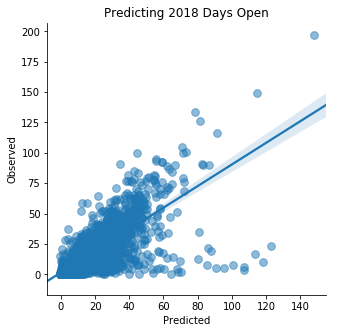

In [56]:
# Fit model to 16-17 data
ridge = Ridge(alpha=10, fit_intercept=True, random_state=44)
ridge.fit(X_1617, y_1617)

# Predict and view stats
predicted_18 = ridge.predict(X_18)
score_18 = r2_score(y_18, predicted_18)
spearman = spearmanr(y_18, predicted_18)
pearson = pearsonr(y_18, predicted_18)
print(f'R-2 score: {score_18:>5.3}')
print(f'Spearman correlation: {spearman[0]:.3}')
#print(f'Pearson correlation: {pearson[0]:.3}')

# scatter plot between predicted days_open and actuals
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=ridge.predict(X_18), y=y_18['days_open'], fit_reg = True, scatter_kws={
    'alpha':0.5, 's':60})

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Predicting 2018 Days Open")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig.savefig('Images/Final_311_Prediction.png')

# Model was 63% accurate.
* This is fairly close to the best cross-validation score of 69.1%.
* The outliers in the lower right represent cases predicted to take 50-130 days to close, but were actually closed in less than 30 days. According to the business motto of "under promise & over deliver", this should be considered a win for 2018.